# Pre-processing data
#### meaning zero fun yet

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.python.keras import layers

print(tf.__version__)

2.9.1


In [3]:
universal_epochs=100

column_names = ['Date', 'Max Temp F', 'Min Temp F', "Precipitation in", 'Snow in', "Snow Depth in"]

raw_dataset = pd.read_csv("D:\\Desktop\\IRP\\data copy.csv", usecols=[0, 2,3,4,5,6], header=1)
# Date begins at 1962-01-01, using numbers cus dates are categorical-ish?

In [4]:
dataset = raw_dataset.copy()

In [5]:
dataset.isna().sum()
# NA VALUES YIKES!!!!!!!!!!
# im just gonna remove those and hope they dont hurt me later cus its like 63 pieces of data out of 20,000+
dataset = dataset.dropna()

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
train_dataset

,Date,TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
1576,1577,75,48.0,0.00,0.0,0.0
11599,11600,48,27.0,0.01,0.0,0.0
10914,10915,51,37.0,0.00,0.0,0.0
16701,16702,45,30.0,0.12,0.0,0.0
1274,1275,94,67.0,0.00,0.0,0.0
...,...,...,...,...,...,...
8234,8235,89,66.0,0.74,0.0,0.0
16590,16591,86,62.0,0.00,0.0,0.0
16322,16323,54,37.0,0.00,0.0,0.0
17311,17312,84,66.0,0.02,0.0,0.0


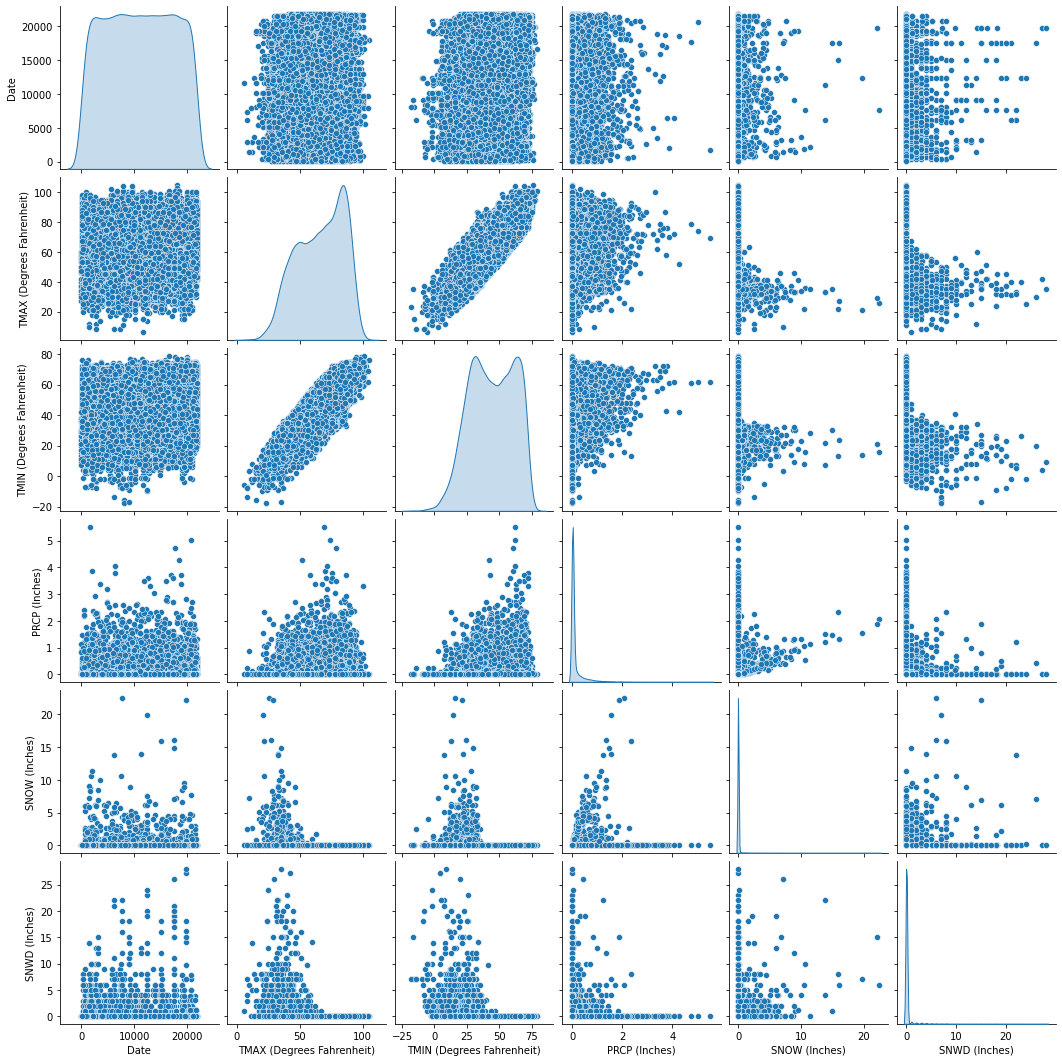

In [8]:
sns.pairplot(train_dataset[['Date', 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)', "PRCP (Inches)", 'SNOW (Inches)', "SNWD (Inches)"]], diag_kind='kde')

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Date,17393.0,10999.424309,6259.099225,1.0,5617.0,11000.0,16410.00,21868.00
TMAX (Degrees Fahrenheit),17393.0,66.114529,18.493142,6.0,51.0,68.0,82.00,105.00
TMIN (Degrees Fahrenheit),17393.0,44.220204,17.222582,-18.0,30.0,44.0,59.00,79.00
PRCP (Inches),17393.0,0.112614,0.317136,0.0,0.0,0.0,0.04,5.52
SNOW (Inches),17393.0,0.056666,0.590180,0.0,0.0,0.0,0.00,22.50
SNWD (Inches),17393.0,0.171109,1.174797,0.0,0.0,0.0,0.00,28.00


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
# I will try to predict max temp given all the other things
train_labels = train_features.pop('TMAX (Degrees Fahrenheit)')
test_labels = test_features.pop('TMAX (Degrees Fahrenheit)')

In [11]:
train_dataset.describe().transpose()[['mean', 'std']] #These values are not normalized which may cause some problems so lets fix that

,mean,std
Date,10999.424309,6259.099225
TMAX (Degrees Fahrenheit),66.114529,18.493142
TMIN (Degrees Fahrenheit),44.220204,17.222582
PRCP (Inches),0.112614,0.317136
SNOW (Inches),0.056666,0.590180
SNWD (Inches),0.171109,1.174797


In [12]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy()) #Since the means print the same then its working alright

[[10999.428    44.22      0.113     0.057     0.171]]


In [13]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy()) # Proof that stuff is normalized properly!!!! WOOHOO!!!!!

First example: [[1577.   48.    0.    0.    0.]]

Normalized: [[-1.51  0.22 -0.36 -0.1  -0.15]]


# Linear Regression with 1 variable cus i might as well try a bunch of stuff
#### some fun but not much

In [14]:
# We're gonna go with min temp cus that makes the most sense to me but this is pretty easy to change
minTemp = np.array(train_features['TMIN (Degrees Fahrenheit)'])

minTemp_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
minTemp_normalizer.adapt(minTemp)

In [15]:
# Build the model
minTemp_model = tf.keras.Sequential([
    minTemp_normalizer,
    layers.Dense(units=1)
])

minTemp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 module_wrapper (ModuleWrapp  (None, 1)                2         
 er)                                                             
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [16]:
# Testing the untrained model (probably wont do very good)
minTemp_model.predict(minTemp[:10])

1/1 [==============================] - 0s 79ms/step


array([[-0.066],
       [ 0.302],
       [ 0.127],
       [ 0.249],
       [-0.4  ],
       [ 0.179],
       [ 0.407],
       [-0.382],
       [-0.242],
       [ 0.337]], dtype=float32)

In [17]:
# Make Model
minTemp_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [18]:
%%time
# Train Model for x epochs
history = minTemp_model.fit(
    train_features['TMIN (Degrees Fahrenheit)'],
    train_labels,
    epochs=universal_epochs,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 46.3 s
Wall time: 31.5 s


In [19]:
# Visualize it
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,6.668844,6.944568,95
96,6.672466,6.932053,96
97,6.672000,6.928510,97
98,6.670868,6.929220,98
99,6.669158,6.930527,99


In [20]:
# Here we make a function to plot this training progress because most people like lines more than numbers but either are available if thats your fancy
# Also its used later too we just define it here cus first time
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Max Temp]')
  plt.legend()
  plt.grid(True)

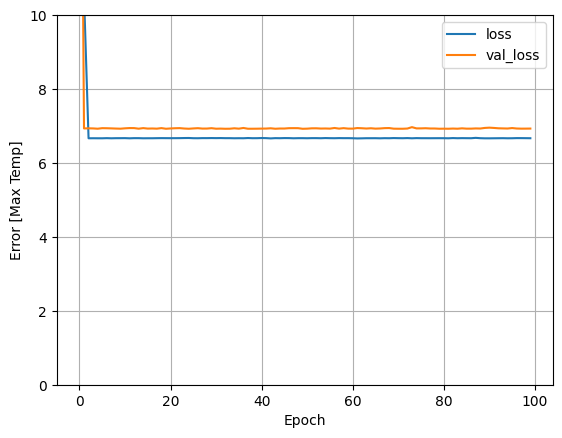

In [21]:
plot_loss(history)

In [22]:
# Save data for comparison later
test_results = {}

test_results['minTemp_model'] = minTemp_model.evaluate(
    test_features['TMIN (Degrees Fahrenheit)'],
    test_labels, verbose=0)

#### here we do some stuff that im honestly not really sure how it works but i do know that it shows a bunch of predictions of the model. Exquisite

In [23]:
x = tf.linspace(0.0, 250, 251)
y = minTemp_model.predict(x)

8/8 [==============================] - 0s 715us/step


In [24]:
def plot_minTemp(x, y):
  plt.scatter(train_features['TMIN (Degrees Fahrenheit)'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('minTemp')
  plt.ylabel('maxTemp')
  plt.legend()

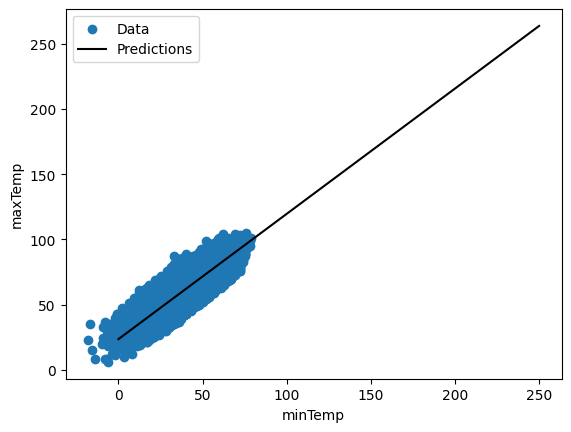

In [25]:
plot_minTemp(x, y)

# Linear Regression with multiple inputs
#### mediocre amounts of fun

In [26]:
# Make model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [27]:
# Test untrained model (not good (unsurprising))
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 31ms/step


array([[-0.967],
       [-0.767],
       [-0.436],
       [-0.12 ],
       [-0.235],
       [-0.166],
       [-1.534],
       [ 0.603],
       [ 0.891],
       [-0.379]], dtype=float32)

In [28]:
# We make sure kernel weights are (9, 1)
# linear_model.layers[1].kernel
# This doesn't work anymore and im not sure why cause a lot of it is copy pasted from tensorflow's wiki...
# Probably deprecated. IDK what it means anyways sooo its not that important

In [29]:
# Make model but actually this time
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [30]:
%%time
# TRAINING!!!!!!!!!!!!!!!
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=universal_epochs,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 45.1 s
Wall time: 30.3 s


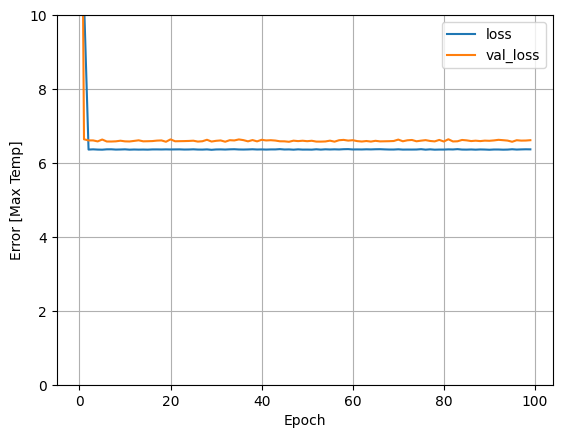

In [31]:
# Genuinely freigthenad (<--- impossible to spell word) spooky results. kinda wishing there was less error no lies
plot_loss(history)

In [32]:
# Save RESULTS!!!!!!
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Regression with DEEP NEURAL NETWORK!!!!! WOOOO
#### mild fun ahead

In [33]:
# We make a function here to build our models because both models will end up using the same thing
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                  optimizer = tf.keras.optimizers.Adam(0.001))
    return model

#### single input (bummer)

In [34]:
# We are gonna make a dnn model with only min temp
dnn_minTemp_model = build_and_compile_model(minTemp_normalizer)

In [35]:
# Overview of the model
dnn_minTemp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 module_wrapper_2 (ModuleWra  (None, 512)              1024      
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 512)              0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              262656    
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 512)             

In [36]:
%%time
# TRAIN IT!!!!!!!
history = dnn_minTemp_model.fit(
    train_features['TMIN (Degrees Fahrenheit)'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=universal_epochs)

CPU times: total: 9min 56s
Wall time: 1min 53s


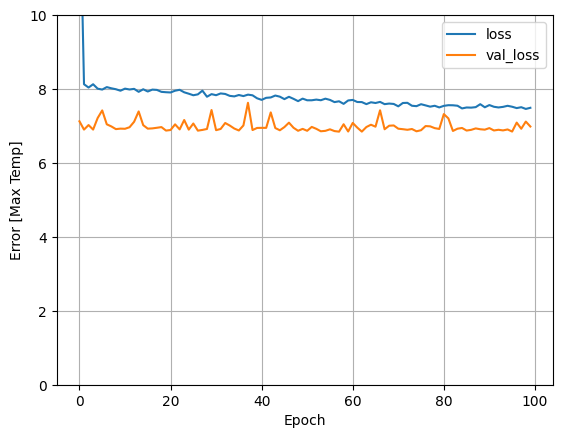

In [37]:
# It should do a smidge better than the linear model 
plot_loss(history)

#### here we do some MORE stuff that im honestly not really sure how it works but i do know that it shows a bunch of predictions of the model. Exquisite

In [38]:
x = tf.linspace(0.0, 250, 251)
y = dnn_minTemp_model.predict(x)

8/8 [==============================] - 0s 1ms/step


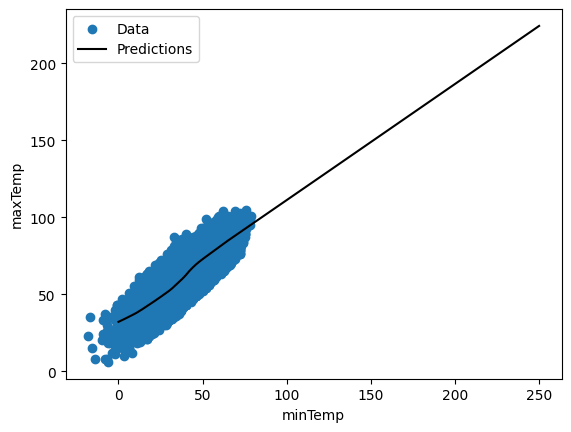

In [39]:
# Hey that looks kinda better not even gonna lie!
plot_minTemp(x, y)

In [40]:
# Save results
test_results['dnn_minTemp_model'] = dnn_minTemp_model.evaluate(
    test_features['TMIN (Degrees Fahrenheit)'], test_labels,
    verbose=0)

# REGRESSION USING DNN WITH MULTIPLE INPUTS!!!!!!!!!! YIPPPEEEEE!!!!
#### super awesome omega fun incoming...

In [41]:
# Make the model and look at an overview of it
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 module_wrapper_7 (ModuleWra  (None, 512)              3072      
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 512)              0         
 pper)                                                           
                                                                 
 module_wrapper_9 (ModuleWra  (None, 512)              262656    
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 512)             

In [42]:
%%time
# TRAIN IT!!!!!!!!!!!!
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=universal_epochs)

CPU times: total: 9min 29s
Wall time: 1min 52s


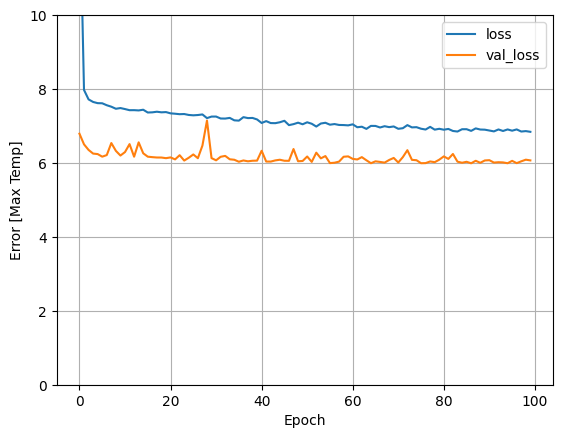

In [43]:
# Plot the loss of the thingggg
plot_loss(history)

In [44]:
# Collect data!!
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Overview of performance
#### boring data (but fun statistics)

In [45]:
# Give a table showing performance of the 4 models
pd.DataFrame(test_results, index=['Mean absolute error [Max Temp]']).T

,Mean absolute error [Max Temp]
minTemp_model,6.892890
linear_model,6.542755
dnn_minTemp_model,6.904729
dnn_model,5.981483


# Predictions
#### kinda cool

136/136 [==============================] - 0s 1ms/step


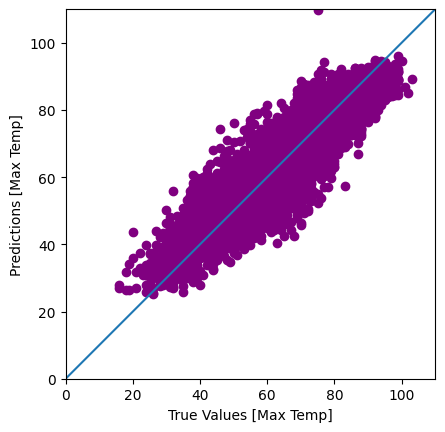

In [46]:
# Make predictions
test_predictions = dnn_model.predict(test_features).flatten()
# Plot it
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, color='purple')
plt.xlabel('True Values [Max Temp]')
plt.ylabel('Predictions [Max Temp]')
lims = [0, 110]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#### ok thats not great im not gonna lie

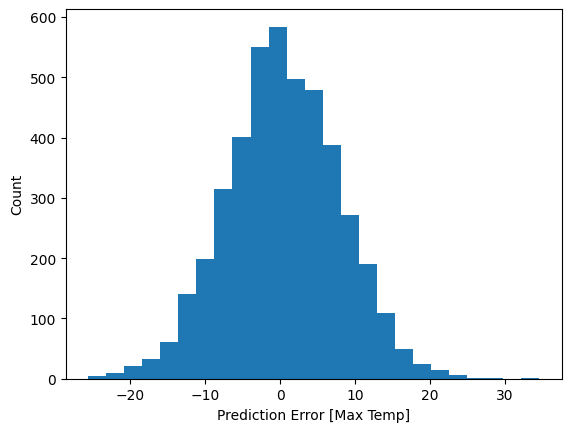

In [47]:
# Lets check the error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Max Temp]')
_ = plt.ylabel('Count')

#### you know it actually isn't too bad, but DEFINITELY has room for improvement 

# Stuff for saving models and such, not really important for making models but important steps for after u have a good one
#### omega boring but required

In [48]:
# Save it
dnn_model.save('dnn_model_testrun')

INFO:tensorflow:Assets written to: dnn_model_testrun\assets


INFO:tensorflow:Assets written to: dnn_model_testrun\assets


In [49]:
#and if u reload it then it will give the same results

reloaded = tf.keras.models.load_model('dnn_model_testrun')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [Max Temp]']).T

,Mean absolute error [Max Temp]
minTemp_model,6.892890
linear_model,6.542755
dnn_minTemp_model,6.904729
dnn_model,5.981483
reloaded,5.981483
